In [1]:
!pip install transformers datasets evaluate torch torchvision gdown rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [28]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, ViTModel,AutoTokenizer
from evaluate import load
from transformers import TrainingArguments, Trainer
import gdown
import zipfile

In [15]:
def download_and_extract(url, output_zip, extract_to):
    if not os.path.exists(output_zip):
        print("Downloading dataset...")
        gdown.download(url, output_zip, quiet=False)

    print("Extracting dataset...")
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Dataset extracted to: {extract_to}")

# Flickr8k dataset Google Drive URL
url = "https://drive.google.com/uc?id=1iFgG55ZUR1ZO-BrIc5PQ1AhrWa0NhQVZ"
output_zip = "flickr8k.zip"
extract_to = "./flickr8k"

# Download and extract
download_and_extract(url, output_zip, extract_to)


Extracting dataset...
Dataset extracted to: ./flickr8k


In [89]:
# Step 2: Define Dataset Class
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, captions_file, image_list_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # Load the image list
        with open(image_list_file, "r") as file:
            self.image_list = set(line.strip() for line in file.readlines())

        # Load captions
        self.image_captions = {}
        with open(captions_file, "r") as file:
            for line in file.readlines():
                image_caption = line.strip().split("\t")
                image_id_caption_number = image_caption[0]
                caption = image_caption[1].strip()
                image_id = image_id_caption_number.split("#")[0]
                if image_id in self.image_list:
                    if image_id in self.image_captions:
                        self.image_captions[image_id].append(caption)
                    else:
                        self.image_captions[image_id] = [caption]

        self.image_ids = list(self.image_captions.keys())
    def get_image_ids(self):
        return self.image_ids

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id)

        # Load and transform image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Get captions
        captions = self.image_captions[image_id]

        return image, captions

In [90]:
folder_path = extract_to + "/flicker8k/"
image_dir = os.path.join(folder_path, "images")
captions_file = os.path.join(folder_path, "Flickr8k.token.txt")
test_list_file = os.path.join(folder_path, "Flickr_8k.testImages.txt")

# Transform for images
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
])

# Create test dataset
test_dataset = Flickr8kDataset(image_dir, captions_file, test_list_file, transform)

In [103]:
def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images)
    return {"pixel_values": images, "captions": captions}

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [101]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(i

In [104]:
model.eval()

generated_captions = []
references = []

for batch in test_dataloader:
    pixel_values = batch["pixel_values"].to(device)

    with torch.no_grad():
        outputs = model.generate(pixel_values, max_length=50)

    # Decode outputs with the correct tokenizer
    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    generated_captions.extend(preds)
    references.extend(batch["captions"])

In [105]:
from evaluate import load

def compute_evaluation_metrics(generated_captions, reference_captions):
    """
    Compute METEOR and ROUGE scores for generated captions.

    Args:
        generated_captions (list of str): Captions generated by the model.
        reference_captions (list of list of str): Reference captions for each image.

    Returns:
        dict: Dictionary containing METEOR, BLEU and ROUGE scores.
    """
    # Load METEOR and ROUGE metrics
    meteor = load("meteor")
    rouge = load("rouge")
    bleu = load("bleu")

    # Compute METEOR score
    meteor_score = meteor.compute(predictions=generated_captions, references=reference_captions)

    # Compute ROUGE scores
    rouge_score = rouge.compute(predictions=generated_captions, references=reference_captions)

    bleu_score = bleu.compute(predictions=generated_captions, references=reference_captions)

    # Aggregate results
    results = {
        "meteor": meteor_score["meteor"],
        "bleu": bleu_score["bleu"],
        "rouge1": rouge_score["rouge1"],
        "rouge2": rouge_score["rouge2"],
        "rougeL": rouge_score["rougeL"],
    }

    return results

In [106]:
metrics = compute_evaluation_metrics(generated_captions, references)

print(f"METEOR Score: {metrics['meteor']}")
print(f"BLEU Score: {metrics['bleu']}")
print(f"ROUGE-1 Score: {metrics['rouge1']}")
print(f"ROUGE-2 Score: {metrics['rouge2']}")
print(f"ROUGE-L Score: {metrics['rougeL']}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.35067308855120655
BLEU Score: 0.13134244538092618
ROUGE-1 Score: 0.4653851061061016
ROUGE-2 Score: 0.2089401155948283
ROUGE-L Score: 0.43346702809750526


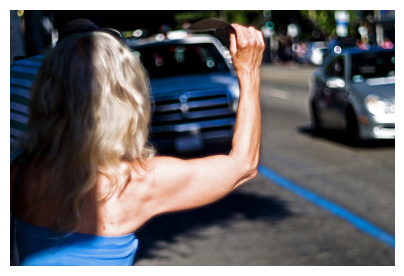

Generated Caption: a woman in a dress standing on a street 
Reference Captions: ['A blond woman in a blue shirt appears to wait for a ride .', 'A blond woman is on the street hailing a taxi .', 'A woman is signaling is to traffic , as seen from behind .', 'A woman with blonde hair wearing a blue tube top is waving on the side of the street .', 'The woman in the blue dress is holding out her arm at oncoming traffic .']
-----------------------------------------------


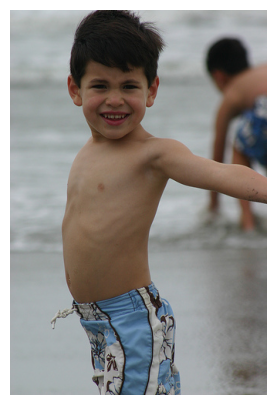

Generated Caption: a young boy standing on a beach with a surfboard 
Reference Captions: ['A boy in his blue swim shorts at the beach .', 'A boy smiles for the camera at a beach .', 'A young boy in swimming trunks is walking with his arms outstretched on the beach .', 'Children playing on the beach .', 'The boy is playing on the shore of an ocean .']
-----------------------------------------------


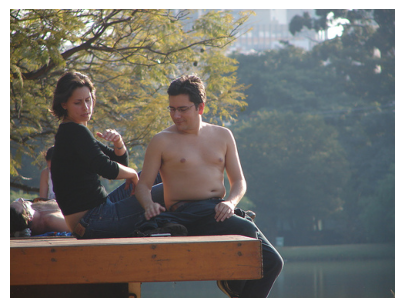

Generated Caption: a man and a woman sitting on a bench 
Reference Captions: ['A lady and a man with no shirt sit on a dock .', 'A man and a woman are sitting on a dock together .', 'A man and a woman sitting on a dock .', 'A man and woman sitting on a deck next to a lake .', 'A shirtless man and a woman sitting on a dock .']
-----------------------------------------------


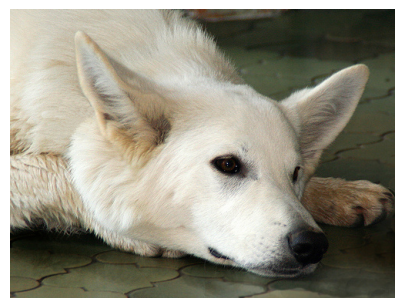

Generated Caption: a white dog laying on a tile floor 
Reference Captions: ['A closeup of a white dog that is laying its head on its paws .', 'a large white dog lying on the floor .', 'A white dog has its head on the ground .', 'A white dog is resting its head on a tiled floor with its eyes open .', 'A white dog rests its head on the patio bricks .']
-----------------------------------------------


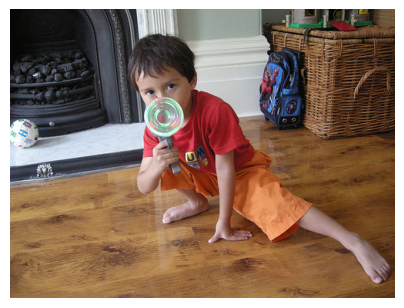

Generated Caption: a small child is playing with a toy 
Reference Captions: ['A boy with a toy gun .', 'A little boy in orange shorts playing with a toy .', 'A young boy with his foot outstretched aims a toy at the camera in front of a fireplace .', 'A young child plays with his new light-up toy .', 'Boy with toy gun pointed at the camera .']
-----------------------------------------------


In [110]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Function to display the original image with captions
def display_original_image_with_captions(dataset, idx, generated_captions, reference_captions):
    """
    Displays the original image along with its generated and reference captions.

    Args:
        dataset (Flickr8kDataset): The dataset instance.
        idx (int): Index of the image to display.
        generated_captions (list of str): List of captions generated by the model.
        reference_captions (list of list of str): List of reference captions for each image.
    """
    # Retrieve the image ID and caption pair
    image_ids = dataset.get_image_ids()
    image_id = image_ids[idx]
    image_path = os.path.join(dataset.image_dir, image_id)

    # Load the original image without transformations
    original_image = Image.open(image_path).convert("RGB")

    # Get the generated and reference captions


    # Display the image
    plt.figure(figsize=(original_image.width / 100, original_image.height / 100))  # Scale figsize based on image size
    plt.imshow(original_image)
    plt.axis('off')  # Hide axes for a cleaner look


    plt.show()


# Display the first 5 images with their captions
for idx in range(5):
    display_original_image_with_captions(test_dataset, idx, generated_captions, references)
    print(f"Generated Caption: {generated_captions[idx]}")
    print(f"Reference Captions: {references[idx]}")
    print("-----------------------------------------------")
